In [1]:
import numpy as np
import pandas as pd 
import random as rn
import tensorflow as tfr
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color
from sklearn.metrics import classification_report
import os
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow_probability as tfp
from keras.optimizers import SGD
import tensorflow as tf
from keras.utils import to_categorical

from tensorflow.keras.layers import MaxPool2D, Dense, ReLU, Softmax, Dropout, Conv2D, Flatten, Conv1D, MaxPool1D, MaxPooling2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras import Sequential
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [4]:
device_list=tf.test.gpu_device_name()
print(device_list)
if device_list!="/device:GPU:0":
    raise SystemError("GPU Device not found")
print("Found GPU at: {}".format(device_list))

/device:GPU:0
Found GPU at: /device:GPU:0


In [5]:
class CNN_FP:

    def __init__(self):

        self.seed = 0

        self.num_pixels=-1
        self.num_classes=-1 #init rand 

        np.random.seed(self.seed) 
        rn.seed(self.seed) # Setting the same seed for repeatability
        tfr.random.set_seed(self.seed)

        self.data_path = '/content/drive/MyDrive/ML_Datasets_Colab_Access/ee456_dataset/inputs/chest_xray/chest_xray/'

        self.train_path = self.data_path + 'train/'
        self.test_path = self.data_path + 'test/'
        self.val_path = self.data_path + 'val/'

        self.img_size = 200

        self.train_df=[]
        self.test_df=[]

        self.train=[]
        self.test=[]

        self.X_train=[]
        self.y_train=[]
        self.X_test=[]
        self.y_test=[]

        self.input_shape = None 

        self.callbacks1=None
        self.callbacks2=None
        self.callbacks3=None
        self.callbacks4=None
        self.callbacks5=None

        self.y_pred=[]
        self.y_pre_test=[] #classes to save as compelx np arrays (n-Dim)

        self.n_classes=2 #t or f

        self.model=None #holder obj

        self.classes=['PNEUMONIA', 'NORMAL']

        self.num_rand_valids=10
        self.batch_size=64
        self.max_epochs=50

    def read_data(self, data_paths):
        
        for data_path in data_paths:
            
            labels = ['PNEUMONIA', 'NORMAL']
            images = []
            y = []
            
            for label in labels:
                curr_path = data_path + label
                for img in os.listdir(curr_path):
                    if ('DS' not in img):
                        
                        image_path = os.path.join(curr_path, img)
                        image =  cv2.resize(cv2.imread(image_path), (self.img_size, self.img_size))
                        
                        if image is not None:
                            images.append([image, label])
                    
        images = np.asarray(images)
        
        return images

    def set_train(self):

        self.train = self.read_data([self.train_path])
        self.test = self.read_data([self.val_path, self.test_path])

        for i in range(10):
            
            np.random.shuffle(self.train)
            np.random.shuffle(self.test)

        self.train_df = pd.DataFrame(self.train, columns=['image', 'label'])
        self.test_df = pd.DataFrame(self.test, columns = ['image', 'label'])
        
        pass

    def explore_plot(self, type_model): #explore 

        plt.figure(figsize=(18, 8))
        sns.set_style("darkgrid")

        plt.subplot(1,2,1)
        sns.countplot(self.train_df['label'], palette = 'coolwarm')
        plt.title('Train data {}'.format(type_model))

        plt.subplot(1,2,2)
        sns.countplot(self.test_df['label'], palette = "hls")
        plt.title('Test data {}'.format(type_model))

        plt.savefig("/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/results/deep/explore_cnn_{}.png".format(type_model))

        pass

    def show_example_image(self, type_model):

        fig = plt.figure(figsize = (16, 16))
        
        for idx in range(15):
            
            plt.subplot(5, 5, idx+1)
            plt.imshow(self.train_df.iloc[idx]['image'])
            plt.title("{} {}".format(self.train_df.iloc[idx]['label'], type_model))
            
        plt.tight_layout()

        plt.savefig("/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/results/deep/image_to_label_{}.png".format(type_model))

        pass

    def splitdata(self, data):#data prep 
        
        X = []
        y = []
        
        for i, (val, label) in enumerate(data):
            
            X.append(val)
            y.append(self.lung_condition(label))
            
        return np.array(X), np.array(y)
    def preprocessing_vgg(self, data):
      data1 = color.rgb2gray(data).reshape(-1, self.img_size, self.img_size, 1).astype('float32')
      data1/=255
        
      return data1
    

    def preprocesing_to_cnn(self, data):
        
        data1 = color.rgb2gray(data).reshape(-1, self.img_size, self.img_size, 1).astype('float32')
        data1/=255
        
        return data1

    def call_pptocnn(self):

        self.X_train = self.preprocesing_to_cnn(self.X_train)
        self.X_test = self.preprocesing_to_cnn(self.X_test)

        self.num_pixels = self.X_train.shape[1] 

        self.y_train = to_categorical(self.y_train)
        self.y_test = to_categorical(self.y_test)

        self.num_classes = self.y_train.shape[1]

        self.input_shape = (self.img_size, self.img_size, 1) ##(self.img_size**2, ) ##(self.img_size, self.img_size, 1)

        self.num_classes = self.y_train.shape[1]
        
        pass

    def make_callbacks(self):

        self.callbacks1 = [EarlyStopping(monitor = 'loss', patience = 6), ReduceLROnPlateau(monitor = 'loss', patience = 3), ModelCheckpoint('models/model.best1.hdf5',monitor='loss', save_best_only=True)]
        self.callbacks3 = [ReduceLROnPlateau(monitor = 'loss', patience = 6), ReduceLROnPlateau(monitor = 'loss', patience = 3), ModelCheckpoint('models/model.best3.hdf5', monitor='loss' , save_best_only=True)]
        self.callbacks2 = [ReduceLROnPlateau(monitor = 'loss', patience = 6), ReduceLROnPlateau(monitor = 'loss', patience = 3),  ModelCheckpoint('models/model.best2.hdf5', monitor='loss' , save_best_only=True)]
        self.callbacks4 = [EarlyStopping(monitor = 'loss', patience = 7), ReduceLROnPlateau(monitor = 'loss', patience = 4), ModelCheckpoint('models/model.best4.hdf5', monitor='loss' , save_best_only=True)]
        self.callbacks5 = [ReduceLROnPlateau(moniter = 'loss', patience = 7), ReduceLROnPlateau(monitor = 'loss', patience = 4), ModelCheckpoint('models/model.best5.hdf5', monitor='loss' , save_best_only=True)]
        
        pass

    def lung_condition(self, label): #pre-proc
        
        if label == 'NORMAL':
            return 0
        
        else:
            return 1

    def set_preproc(self):

        np.random.shuffle(self.train)
        np.random.shuffle(self.test)
        self.X_train, self.y_train = self.splitdata(self.train) #overwrites 
        self.X_test, self.y_test = self.splitdata(self.test)
        
        pass

    def preprocesing_to_mlp(self, data):
        
        data1 = color.rgb2gray(data).reshape(-1, self.img_size * self.img_size).astype('float32')
        
        data1 /= 255 # Data Normalization [0, 1]
        
        return data1

    def mlp_tt(self): 

        self.X_train = self.preprocesing_to_mlp(self.X_train)
        self.X_test = self.preprocesing_to_mlp(self.X_test)

        self.num_pixels = self.X_train.shape[1] 

        self.y_train = to_categorical(self.y_train)
        self.y_test = to_categorical(self.y_test)

        self.num_classes = self.y_train.shape[1]

        self.input_shape = (self.img_size, self.img_size, 1) ##(self.img_size**2, ) ##(self.img_size, self.img_size, 1)

        self.num_classes = self.y_train.shape[1]

        pass

    def draw_learning_curve(self, history, type_model):

        epochs_arr=[]

        if type_model=="mlp1":
            epochs_arr=np.arange(0,self.max_epochs)

        elif type_model=="mlp2":
            epochs_arr=np.arange(0,2*self.max_epochs)

        elif type_model=="cnn1":
            epochs_arr=np.arange(0,2*self.max_epochs)

        elif type_model=='vgg':
            epochs_arr=np.arange(0,self.max_epochs)

        fig = plt.figure(figsize = (16,12))

        y_1=np.array(history.history["accuracy"])
        y_2=np.array(history.history["val_accuracy"])

        plt.plot(epochs_arr, y_1, label="train") 
        plt.plot(epochs_arr, y_2, label="test")

        plt.xlabel("Epochs")
        plt.ylabel("Accuracy Metric")

        plt.legend(loc='best')
        plt.grid(True)

        plt.title("Accuracy (Train + Test vs. Epochs) {}".format(type_model))

        plt.savefig("/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/results/deep/"+"acc_{}.png".format(type_model))

        fig = plt.figure(figsize = (16,12))

        y_1=np.array(history.history["loss"])
        y_2=np.array(history.history["val_loss"])

        plt.plot(epochs_arr, y_1, label="train") 
        plt.plot(epochs_arr, y_2, label="test")

        plt.xlabel("Epochs")
        plt.ylabel("Loss Metric")

        plt.legend(loc='best')
        plt.grid(True)

        plt.title("Loss (Train + Test vs. Epochs) {}".format(type_model))

        plt.savefig("/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/results/deep/"+"loss_{}.png".format(type_model))

        pass

    def get_mlp(self): #mlp layer, IO premade 
            
        return Sequential([Dense(1024, input_dim = self.num_pixels, activation='relu'), Dense(self.num_classes, activation='softmax')])

    def eval_model1(self, type_model):

        #self.model = load_model('/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/models/model.best1.hdf5')

        x_train_now=self.X_train#.flatten() #np.reshape(self.X_train, self.input_shape).flatten()
        y_train_now=self.y_train#.flatten() #np.reshape(self.y_train, self.input_shape).flatten()

        x_test_now=self.X_test#.flatten()
        y_test_now=self.y_test#.flatten()

        learning_history = self.model.fit(x_train_now, y_train_now, batch_size = self.batch_size, epochs = self.max_epochs, verbose = 2, callbacks = self.callbacks1, validation_data=(x_test_now, y_test_now))

        self.draw_learning_curve(learning_history, type_model)

        self.y_pred=self.model.predict(x_test_now)

        metric = tf.keras.metrics.TopKCategoricalAccuracy(k=1) 
        metric.update_state(y_test_now, self.y_pred)
        acc=metric.result().numpy()
       
        print("Overall Precision Accuracy for model {}: {}".format(type_model, acc))

        metric_r=tf.keras.metrics.Recall()
        metric_r.update_state(y_test_now, self.y_pred)

        acc_r=metric_r.result().numpy()

        print("Overall Recall Accuracy for model {}: {}".format(type_model, acc_r))

        preds=np.argmax(self.y_pred, axis=-1) 
        labels=np.argmax(y_test_now, axis=1)

        print(classification_report(labels,preds, target_names=self.classes))

        score = self.model.evaluate(x_test_now, y_test_now, verbose = 0)
        print('Test loss for model {}: {}%'.format(type_model, score[0] * 100))
        print('Test accuracy for model {}: {}%'.format(type_model, score[1] * 100))

        print("MLP Error for model {}: {}".format(type_model, 100 - score[1] * 100))

        self.plot_confusion(type_model)
        self.random_validations(type_model)

        pass

    def plot_confusion(self, type_model):

        preds=np.argmax(self.y_pred, axis=-1) 
        labels=np.argmax(self.y_test, axis=-1)

        df_cm = confusion_matrix(labels, preds)

        t=df_cm[0][0]
        df_cm[0][0]=df_cm[0][1]
        df_cm[0][1]=t #swap for right conf matr

        t=df_cm[1][1]
        df_cm[1][1]=df_cm[0][0]
        df_cm[0][0]=t #other swap for right class numbers 
        
        plt.figure(figsize = (20,20))

        sn.heatmap(df_cm, annot=True, cmap="icefire", linewidths=1, cbar=False, xticklabels=self.classes, yticklabels=self.classes)

        plt.xlabel("True")
        plt.title("Confusion Matrix for Test and Validation: {}".format(type_model))
        plt.ylabel("Predicted")

        plt.savefig("/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/results/deep/"+"cm_{}.png".format(type_model), dpi=100)

        pass

    def random_validations(self, type_model):
        
        for i in range(self.num_rand_valids):

            p_test = self.model.predict(self.X_test).argmax(axis=1)
                            
            j = np.random.randint(0, len(self.X_test))

            plt.figure(figsize = (12,12))

            img_j=np.reshape(self.X_test[j], (self.img_size, self.img_size))

            plt.imshow(img_j, cmap='gray')
            yv=np.where(self.y_test[j]==1)[0][0]

            pvc=np.max(self.y_pred[j])

            plt.title("True label: {}, Predicted: {} with confidence: {} : {}".format(self.classes[yv], self.classes[p_test[j]], pvc, type_model))

            plt.savefig("/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/results/deep/pic_{}_{}.png".format(i, type_model))

        pass #not plotted precision and recall per epich, as irrelevant to metric study 

    def pre_m(self): #model 1

        self.model=self.get_mlp()
        self.model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        print(self.model.summary())

        pass

    def get_mlpv2(self):#model 2
            
        return Sequential([
            Dense(1024, input_dim=self.num_pixels, activation='relu'), 
            Dropout(0.4), 
            Dense(512, activation='relu'), 
            Dropout(0.3), 
            Dense(128, activation='relu'), 
            Dropout(0.3), 
            Dense(self.num_classes, activation='softmax')])

    def pre_m2(self):

        self.model = self.get_mlpv2()
        self.model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        print(self.model.summary())

        pass

    def eval_model2(self, type_model):

        #self.model = load_model('/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/models/model.best2.hdf5')

        x_train_now=self.X_train#.flatten() #np.reshape(self.X_train, self.input_shape).flatten()
        y_train_now=self.y_train#.flatten() #np.reshape(self.y_train, self.input_shape).flatten()

        x_test_now=self.X_test#.flatten()
        y_test_now=self.y_test#.flatten()

        learning_history = self.model.fit(x_train_now, y_train_now, batch_size = self.batch_size, epochs = self.max_epochs*2, verbose = 2, callbacks = self.callbacks2, validation_data=(x_test_now, y_test_now))

        score = self.model.evaluate(self.X_test, self.y_test, verbose = 0)
        print('Test loss for model {}: {}%'.format(type_model, score[0] * 100))
        print('Test accuracy for model {}: {}%'.format(type_model, score[1] * 100))

        print("MLP Error for model {}: {}".format(type_model, 100 - score[1] * 100))

        self.draw_learning_curve(learning_history, type_model)

        self.y_pred=self.model.predict(x_test_now)

        metric = tf.keras.metrics.TopKCategoricalAccuracy(k=1) 
        metric.update_state(y_test_now, self.y_pred)
        acc=metric.result().numpy()
       
        print("Overall Precision Accuracy for model {}: {}".format(type_model, acc))

        metric_r=tf.keras.metrics.Recall()
        metric_r.update_state(y_test_now, self.y_pred)

        acc_r=metric_r.result().numpy()

        print("Overall Recall Accuracy for model {}: {}".format(type_model, acc_r))

        preds=np.argmax(self.y_pred, axis=-1) 
        labels=np.argmax(y_test_now, axis=1)

        print(classification_report(labels,preds, target_names=self.classes))

        self.plot_confusion(type_model)
        self.random_validations(type_model)

        pass

    def data_aug(self): #data aug

        datagen = ImageDataGenerator(featurewise_center = False, 
                                     samplewise_center = False, 
                                     featurewise_std_normalization = False, 
                                     samplewise_std_normalization = False, 
                                     zca_whitening = False, 
                                     horizontal_flip = False, 
                                     vertical_flip = False, 
                                     rotation_range = 10, 
                                     zoom_range = 0.1, 
                                     width_shift_range = 0.1, 
                                     height_shift_range = 0.1)

        datagen.fit(self.X_train)
        self.train_gen = datagen.flow(self.X_train, self.y_train, batch_size = 32)

        pass

    def get_modelvgg(self): #VGG model
        return Sequential([Conv2D(input_shape= self.input_shape ,filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                           Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                           MaxPool2D(pool_size=(2,2),strides=(2,2)),
                           Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                           Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                           MaxPool2D(pool_size=(2,2),strides=(2,2)),
                           Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                           Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                           Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                           MaxPool2D(pool_size=(2,2),strides=(2,2)),
                           Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                           Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                           Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                           MaxPool2D(pool_size=(2,2),strides=(2,2)),
                           Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                           Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                           Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                           MaxPool2D(pool_size=(2,2),strides=(2,2)),
                           Flatten(),
                           Dense(units=4096,activation="relu"),
                           Dense(units=4096,activation="relu"),
                           Dense(self.num_classes, activation="softmax")])
        
    def get_modelvgg2(self): #VGG modelv2
        standard = VGG16(weights=None, include_top=False, input_shape = self.input_shape)
        for layer in standard.layers: #layers are pre-trained
          layer.trainable=False
        
        return Sequential([standard,
                           Flatten(),
                           Dense(units=4096,activation="relu"),
                           Dense(units=4096,activation="relu"),
                           Dense(self.num_classes, activation="softmax")])
    
    def eval_vgg(self, type_model):

        self.model = self.get_modelvgg2()
        opt = SGD(learning_rate=1e-6)
        self.model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        #self.model.summary()

        x_train_now=self.X_train
        y_train_now=self.y_train

        x_test_now=self.X_test
        y_test_now=self.y_test
        learning_history = self.model.fit(x_train_now, y_train_now, batch_size = 32, epochs = 50, verbose = 1, callbacks = self.callbacks5, validation_data = (x_test_now, y_test_now))
        #learning_history = self.model.fit_generator(self.train_gen,
                                                    #epochs = 50,
                                                    #steps_per_epoch = self.X_train_now.shape[0] // 32, 
                                                    #validation_data = (x_test_now,y_test_now), 
                                                    #callbacks = self.callbacks5)

        score = self.model.evaluate(self.X_test, self.y_test, verbose = 0)
        print('Test loss for model {}: {}%'.format(type_model, score[0]))
        print('Test accuracy for model {}: {}%'.format(type_model, score[1] * 100))

        print("MLP Error for model {}: {}".format(type_model, 100 - score[1] * 100))

        self.draw_learning_curve(learning_history, type_model)

        self.y_pred=self.model.predict(x_test_now)

        metric = tf.keras.metrics.TopKCategoricalAccuracy(k=1) 
        metric.update_state(y_test_now, self.y_pred)
        acc=metric.result().numpy()
       
        print("Overall Precision Accuracy for model {}: {}".format(type_model, acc))

        metric_r=tf.keras.metrics.Recall()
        metric_r.update_state(y_test_now, self.y_pred)

        acc_r=metric_r.result().numpy()

        print("Overall Recall Accuracy for model {}: {}".format(type_model, acc_r))

        preds=np.argmax(self.y_pred, axis=-1) 
        labels=np.argmax(y_test_now, axis=1)

        print(classification_report(labels,preds, target_names=self.classes))

        self.plot_confusion(type_model)
        self.random_validations(type_model)

        pass

    def get_modelcnn(self): #CNN model

        return Sequential([Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = self.input_shape), 
                           Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'), 
                           BatchNormalization(), 
                           MaxPool2D(pool_size=(2, 2)), 
                           Dropout(0.25), 
                           Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'), 
                           Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'), 
                           BatchNormalization(), 
                           MaxPool2D(pool_size=(2, 2)), 
                           Dropout(0.25), 
                           Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'), 
                           Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'), 
                           BatchNormalization(), 
                           MaxPool2D(pool_size=(2, 2)), 
                           Dropout(0.25), 
                           Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ), 
                           Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'), 
                           BatchNormalization(), 
                           MaxPool2D(pool_size=(2, 2)), 
                           Dropout(0.25), 
                           Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ), 
                           Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'), 
                           BatchNormalization(), 
                           MaxPool2D(pool_size=(2, 2)), 
                           Dropout(0.25), 
                           Flatten(), 
                           Dense(512, activation='relu'), 
                           Dropout(0.5), 
                           Dense(256, activation='relu'), 
                           Dropout(0.5), 
                           Dense(64, activation='relu'), 
                           Dropout(0.5), 
                           Dense(self.num_classes, activation = "softmax")])

    def eval_cnn_m1(self, type_model): #fit and eval cnn 1

        self.model = self.get_modelcnn()
        self.model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

        x_train_now=self.X_train#.flatten() #np.reshape(self.X_train, self.input_shape).flatten()
        y_train_now=self.y_train#.flatten() #np.reshape(self.y_train, self.input_shape).flatten()

        x_test_now=self.X_test#.flatten()
        y_test_now=self.y_test#.flatten()

        learning_history = self.model.fit(x_train_now, y_train_now, batch_size = 64, epochs = 100, verbose = 1, callbacks = self.callbacks3, validation_data = (x_test_now, y_test_now))

        #self.model = load_model('/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/models/model.best3.hdf5')

        score = self.model.evaluate(self.X_test, self.y_test, verbose = 0)
        print('Test loss for model {}: {}%'.format(type_model, score[0]))
        print('Test accuracy for model {}: {}%'.format(type_model, score[1] * 100))

        print("MLP Error for model {}: {}".format(type_model, 100 - score[1] * 100))

        self.draw_learning_curve(learning_history, type_model)

        self.y_pred=self.model.predict(x_test_now)

        metric = tf.keras.metrics.TopKCategoricalAccuracy(k=1) 
        metric.update_state(y_test_now, self.y_pred)
        acc=metric.result().numpy()
       
        print("Overall Precision Accuracy for model {}: {}".format(type_model, acc))

        metric_r=tf.keras.metrics.Recall()
        metric_r.update_state(y_test_now, self.y_pred)

        acc_r=metric_r.result().numpy()

        print("Overall Recall Accuracy for model {}: {}".format(type_model, acc_r))

        preds=np.argmax(self.y_pred, axis=-1) 
        labels=np.argmax(y_test_now, axis=1)

        print(classification_report(labels,preds, target_names=self.classes))

        self.plot_confusion(type_model)
        self.random_validations(type_model)

        pass

    def get_modelcnn_v2(self): #cnn model 2:

        return Sequential([
            Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = self.input_shape), 
            Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'), 
            BatchNormalization(), 
            MaxPool2D(pool_size=(2, 2)), 
            Dropout(0.2), 
            Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'), 
            Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'), 
            BatchNormalization(), 
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.2), 
            Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'), 
            Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'), 
            BatchNormalization(), 
            MaxPool2D(pool_size=(2, 2)), 
            Dropout(0.2), 
            Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
            Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'), 
            BatchNormalization(), 
            MaxPool2D(pool_size=(2, 2)), 
            Dropout(0.2), 
            Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'), 
            Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'), 
            BatchNormalization(), 
            MaxPool2D(pool_size=(2, 2)), 
            Dropout(0.2), 
            Flatten(), 
            Dense(1024, activation='relu'), 
            BatchNormalization(), 
            Dropout(0.5), 
            Dense(512, activation='relu'), 
            BatchNormalization(), 
            Dropout(0.4), 
            Dense(256, activation='relu'), 
            BatchNormalization(), 
            Dropout(0.3), 
            Dense(64, activation='relu'), 
            BatchNormalization(), 
            Dropout(0.2), 
            Dense(self.num_classes, activation = "softmax")])

    def eval_cnn_model2(self, type_model):

        self.model = self.get_modelcnn_v2()
        self.model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        self.model.summary()

        learning_history = self.model.fit_generator((self.train_gen), epochs = 100, steps_per_epoch = self.X_train.shape[0] // 32, validation_data = (self.X_test, self.y_test), callbacks = self.callbacks4)

        #self.model = load_model('/content/drive/MyDrive/ML_Datasets_Colab_Access/EE_456/models/model.best4.hdf5')

        score = self.model.evaluate(self.X_test, self.y_test, verbose = 0)
        print('Test loss: {}%'.format(score[0] * 100))
        print('Test accuracy: {}%'.format(score[1] * 100))

        print("MLP Error: %.2f%%" % (100 - score[1] * 100))

        self.draw_learning_curve(learning_history, type_model)

        y_pred = self.model.predict(self.X_test) #pred 2
        self.y_pred = np.argmax(y_pred, axis = 1)

        self.y_pre_test = np.argmax(self.y_test, axis = 1)

        pass

    def show_condition(self, num):
        
        if num == 0:
            return 'NORMAL'
        
        return 'PNEUMONIA'

    def final_classification(self, type_model):

        cnt_error = []
        for idx, (a, b) in enumerate(zip(self.y_pre_test, self.y_pred)):
            if a == b: 
                continue
            cnt_error.append(a)# test

        cnt_error = np.unique(cnt_error, return_counts = True)
        sns.set_style("darkgrid")
        plt.figure(figsize = (15, 7))
        sns.barplot([self.show_condition(x) for x in cnt_error[0]], cnt_error[1], palette="muted")
        
        plt.savefig("results/deep/final_class_{}.png".format(type_model))

        cnt_ind = 1
        list_idx = []
        fig = plt.figure(figsize=(14, 14))
        X_test_plot = self.X_test.reshape(-1, self.img_size, self.img_size)
        
        for idx, (a, b) in enumerate(zip(self.y_pre_test, self.y_pred)):
            
            if(cnt_ind > 16):
                break
            
            if a == b: 
                continue
            
            plt.subplot(4, 4, cnt_ind)
            plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
            plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(self.show_condition(a), self.show_condition(b), idx))
            plt.tight_layout()
            list_idx.append(idx)
            cnt_ind += 1

            

        print(classification_report(self.y_pre_test, self.y_pred)) #report class

        pass

    def run_sequence_model1(self): #model 1 normal mlp

        type_model="mlp1"
        
        print("\nRunning MLP Model #1 ... \n")

        self.set_train()
        self.explore_plot(type_model)
        self.show_example_image(type_model)
        self.set_preproc()
        self.mlp_tt()
        
        self.make_callbacks()
        self.pre_m()
        self.eval_model1(type_model)
        
        print("\nMLP Model 1 Generated. \n")

        pass

    def run_sequence_model2(self): #model 2 normal mlp

        type_model="mlp2"
        
        print("\nRunning MLP Model #2 ... \n")
    
        self.set_train()
        self.explore_plot(type_model)
        self.show_example_image(type_model)
        self.set_preproc()
        self.mlp_tt()
        
        self.make_callbacks()
        self.pre_m2()
        self.eval_model2(type_model)
        
        print("\nMLP Model 2 Generated. \n")

        pass

    def run_sequence_model3(self): #cnn layers v1

        type_model="cnn1"
        
        print("\nRunning CNN Model #1 ... \n")

        self.set_train()
        self.explore_plot(type_model)
        self.show_example_image(type_model) #added from MLPs

        self.set_preproc()
        self.call_pptocnn()

        self.make_callbacks()
        self.get_modelcnn()
        self.eval_cnn_m1(type_model)
        
        print("\nCNN Model 1 Generated. \n")

        pass

    def run_sequence_model4(self): #cnn model v2

        type_model="cnn2"
        
        print("\nRunning CNN Model #2 ... \n")
    
        self.data_aug()
        self.make_callbacks()

        self.get_modelcnn_v2()
        self.eval_cnn_model2(type_model)
        self.final_classification()
        
        print("\nCNN Model 2 Generated. \n")
        
        pass

    def run_sequence_model5(self): #vgg16

        type_model="vgg"
        
        print("\nRunning VGG Model #1 ... \n")

        self.set_train()
        #self.explore_plot(type_model)
        #self.show_example_image(type_model)

        #self.data_aug()
        self.set_preproc()
        self.call_pptocnn()
        self.make_callbacks()
        self.get_modelvgg2()
        self.eval_vgg(type_model)
        
        print("\VGG Model 1 Generated. \n")

        pass


Running VGG Model #1 ... 

Epoch 1/50
163/163 [==============================] - 44s 206ms/step - loss: 0.6931 - accuracy: 0.7349 - val_loss: 0.6931 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 2/50
163/163 [==============================] - 28s 172ms/step - loss: 0.6931 - accuracy: 0.7428 - val_loss: 0.6931 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 3/50
163/163 [==============================] - 30s 187ms/step - loss: 0.6931 - accuracy: 0.7428 - val_loss: 0.6931 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 4/50
163/163 [==============================] - 28s 175ms/step - loss: 0.6930 - accuracy: 0.7428 - val_loss: 0.6931 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 5/50
163/163 [==============================] - 28s 175ms/step - loss: 0.6930 - accuracy: 0.7428 - val_loss: 0.6931 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 6/50
163/163 [==============================] - 28s 173ms/step - loss: 0.6929 - accuracy: 0.7428 - val_loss: 0.6930 - val_accuracy: 0.6250 - lr: 1.0000e-06


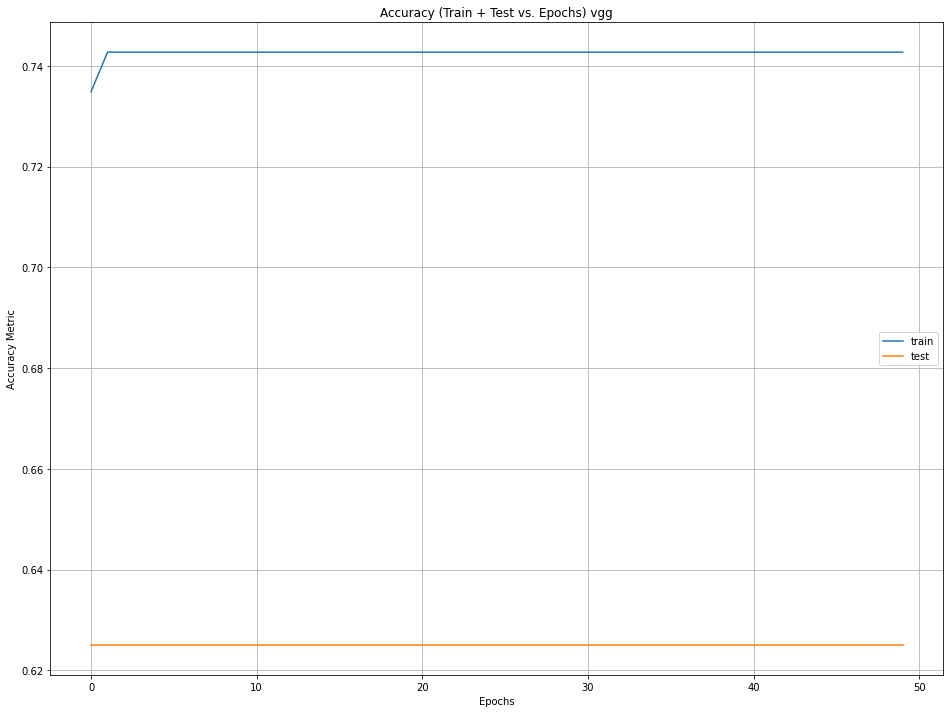

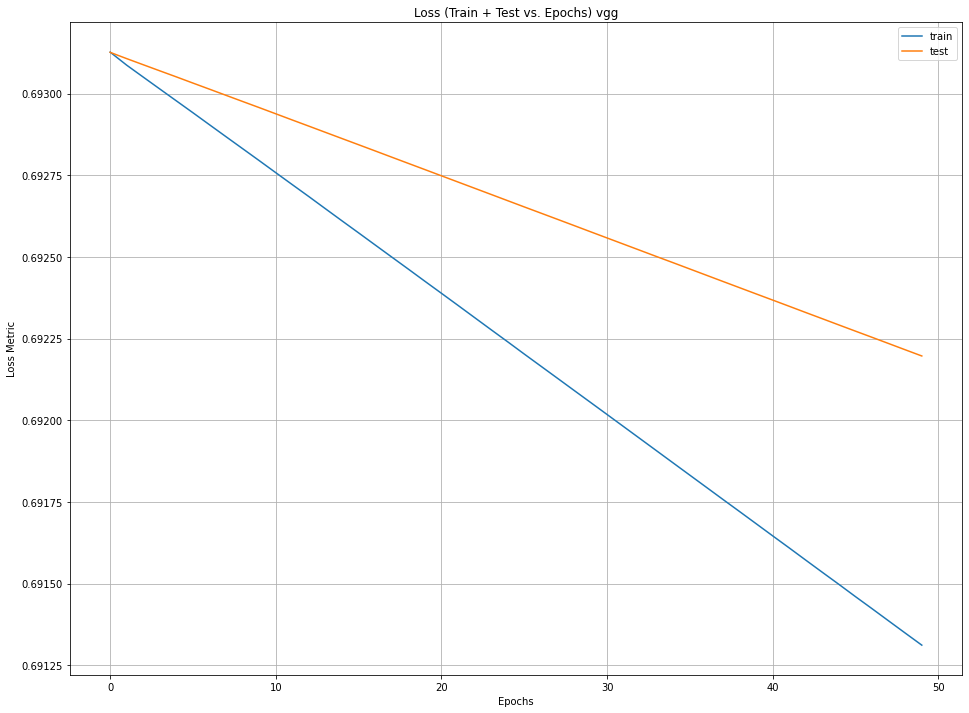

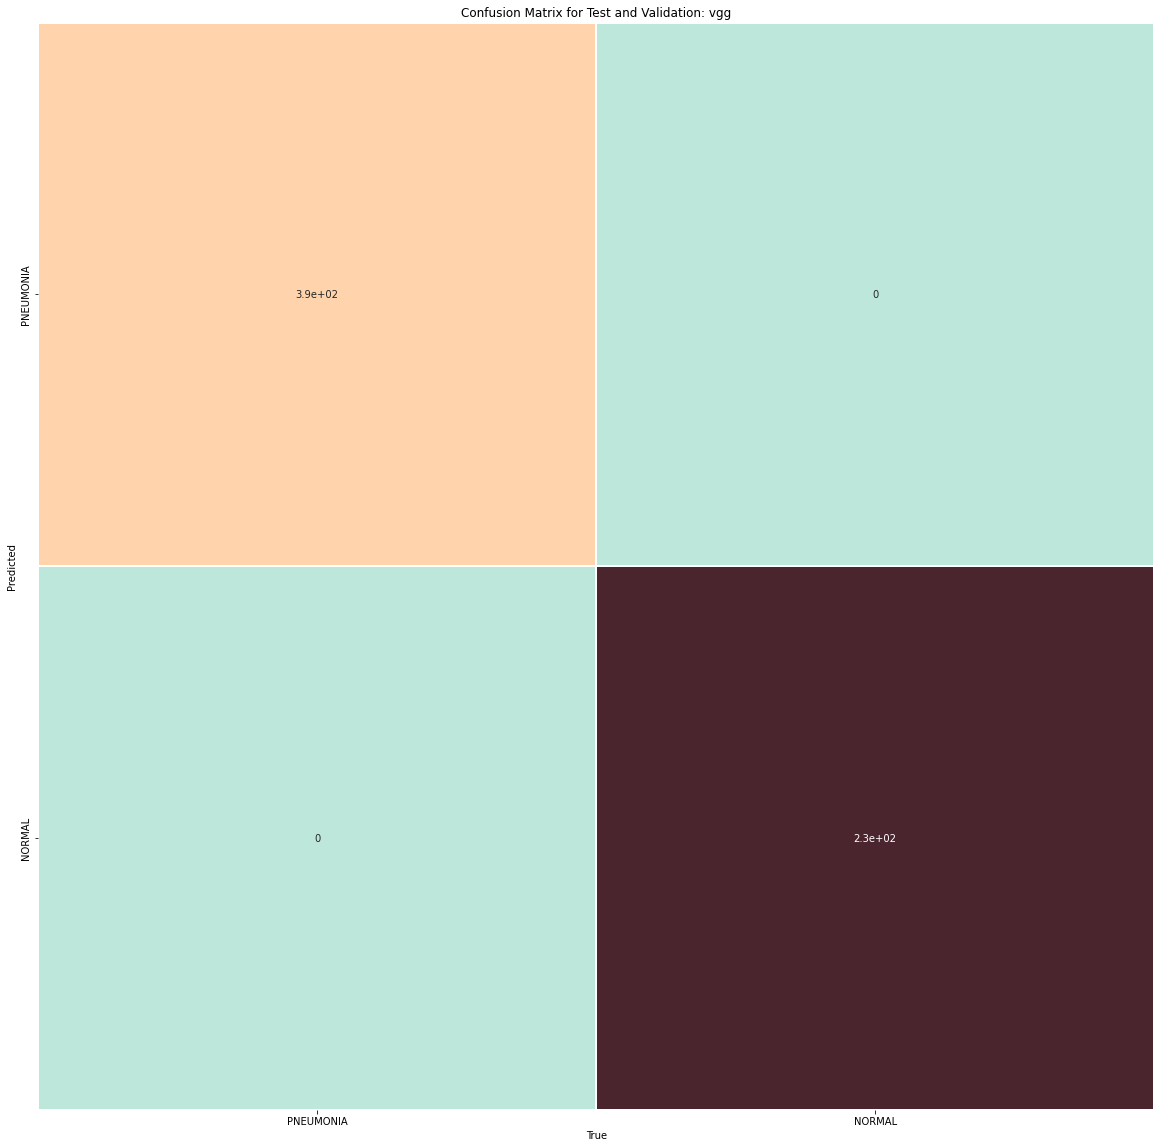

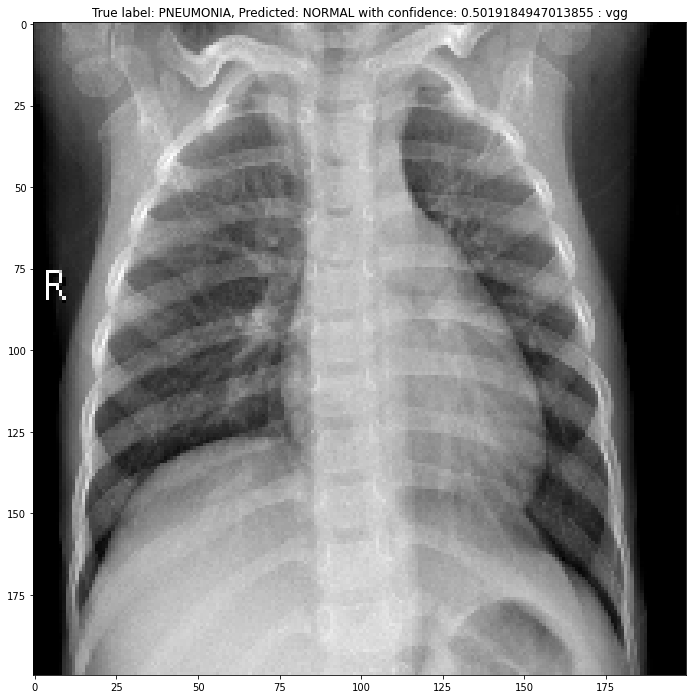

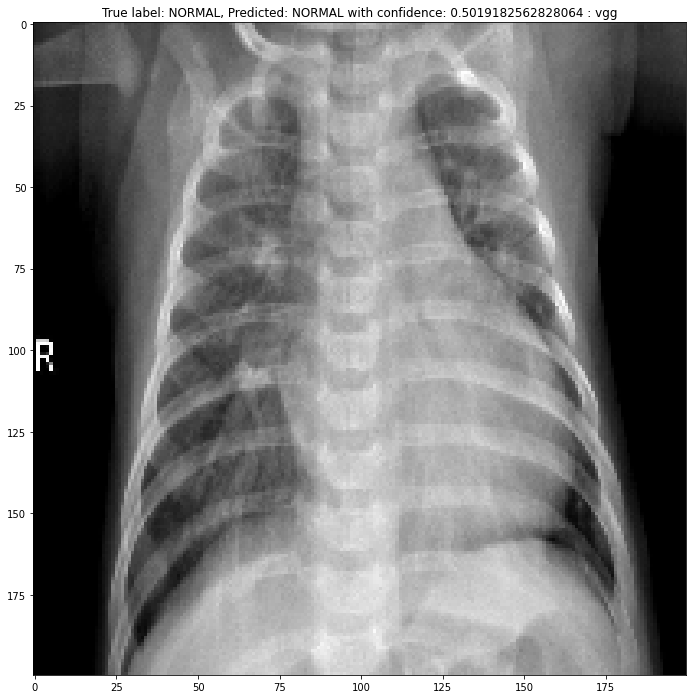

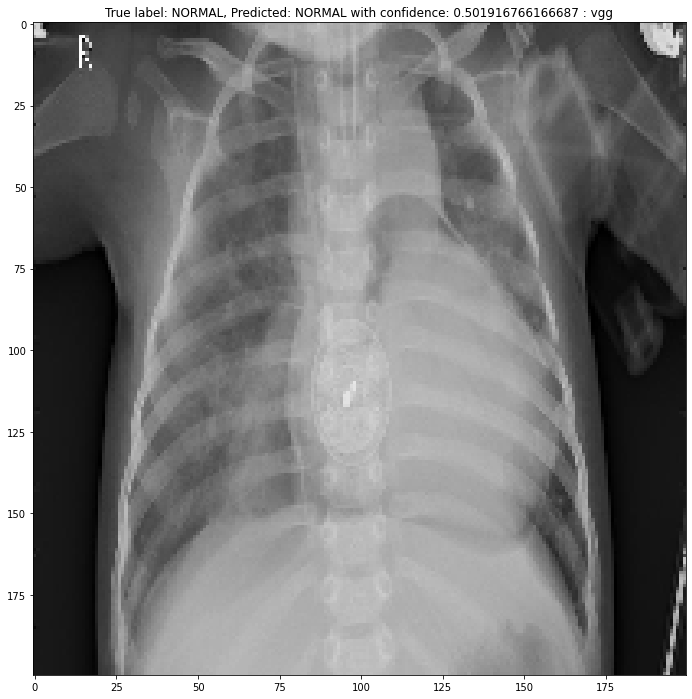

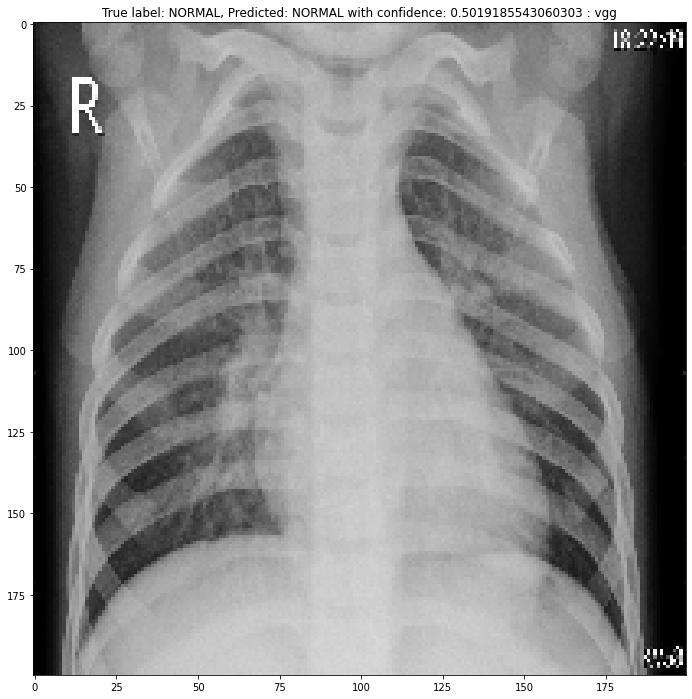

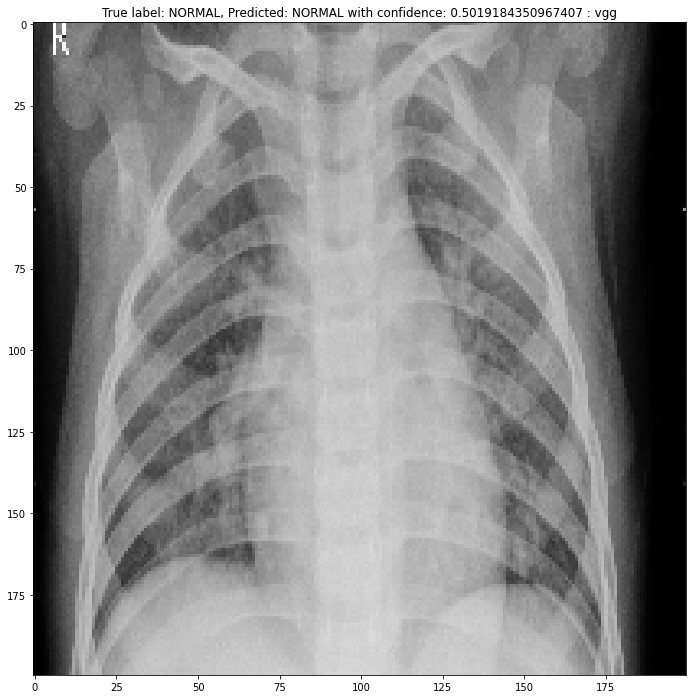

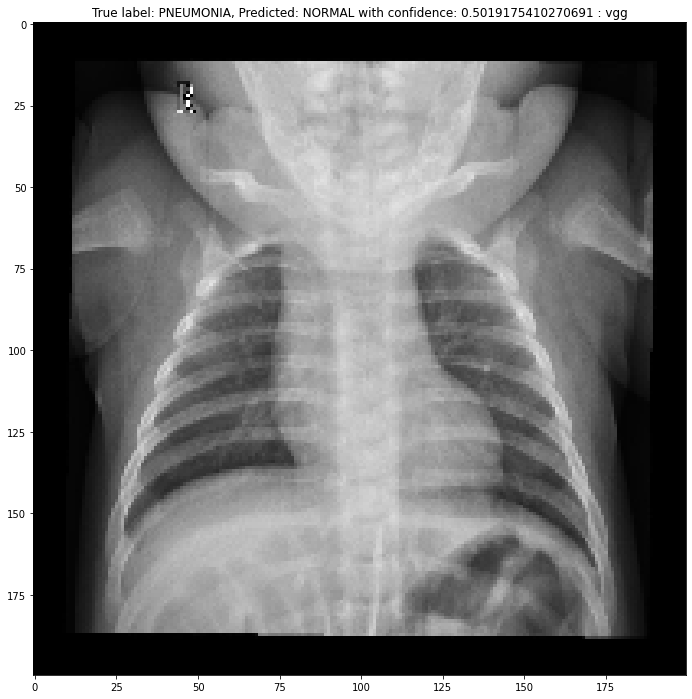

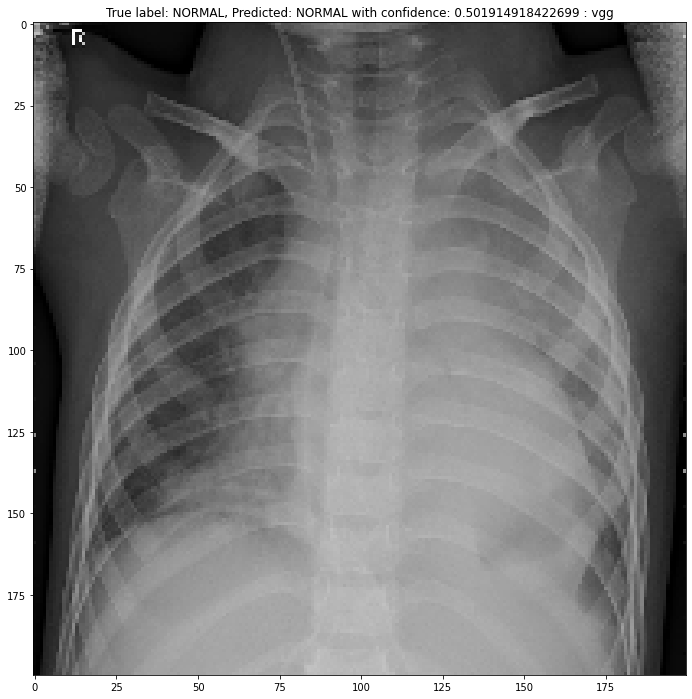

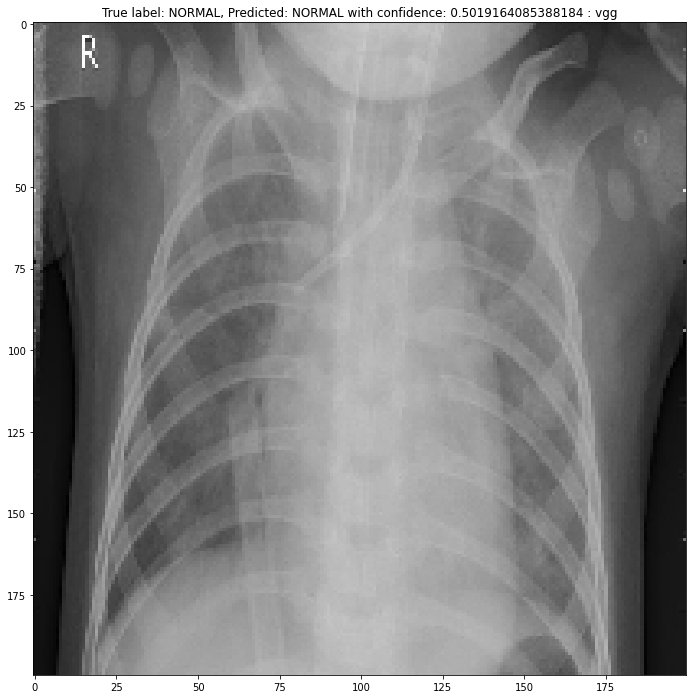

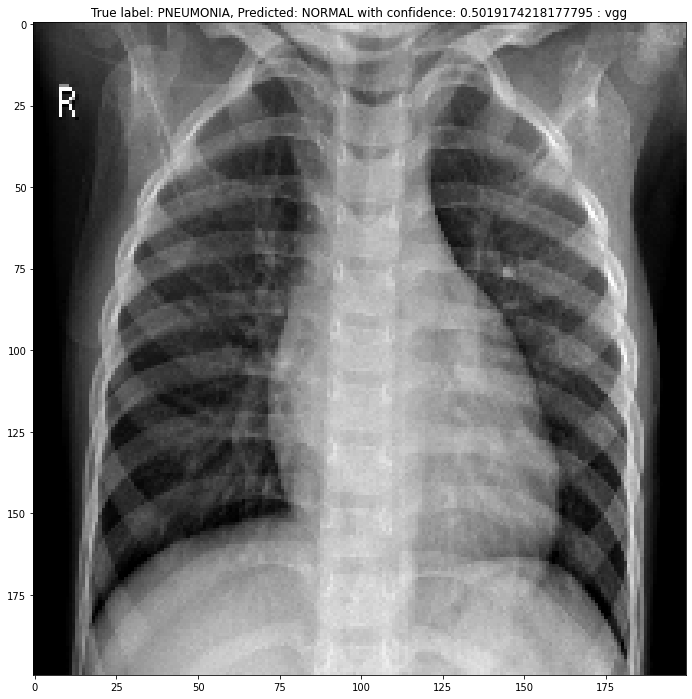

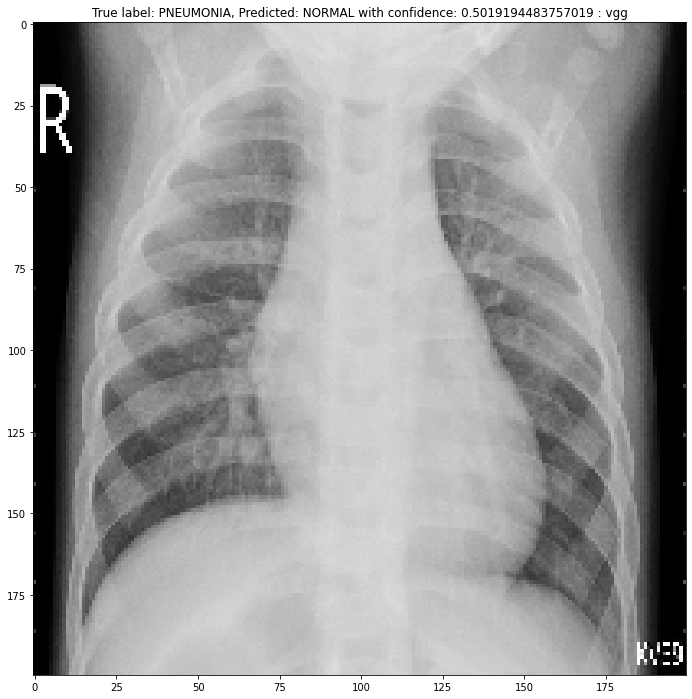

In [6]:
#start

if __name__=="__main__":

    cfp=CNN_FP()
    #cfp.run_sequence_model1()
    #cfp.run_sequence_model2()
    #cfp.run_sequence_model3() #only 1 deep CNN
    #cfp.run_sequence_model4()
    cfp.run_sequence_model5()

#end
     